# ═══════════════════════════════════════════════════════════════════════════════
# NOTEBOOK 00: CREATE SPLIT SAMPLES FOR AIRS SCALE VALIDATION
# ═══════════════════════════════════════════════════════════════════════════════

**Purpose**: Prepare AIRS survey data for split-sample validation (EFA → CFA pipeline)

**Design Decisions**:
- **Population**: All respondents (students + professionals) per approved dissertation proposal
- **Split Strategy**: 50/50 split for balanced EFA/CFA samples
- **Stratification**: By AI adoption status to ensure comparable samples

**Outputs**:
- `AIRS_experiment.csv` → EFA development sample
- `AIRS_holdout.csv` → CFA holdout sample
- `experiment_config.json` → Configuration metadata for downstream notebooks

In [14]:
# ═══════════════════════════════════════════════════════════════════════════════
# CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════
import pandas as pd
import numpy as np
import json
from datetime import datetime
from sklearn.model_selection import train_test_split

# Split-sample parameters
HOLDOUT_RATIO = 0.50  # 50/50 split for balanced EFA/CFA
RANDOM_SEED = 67      # Reproducibility

# AIRS Scale Items (28 total: 24 predictors + 4 BI outcomes)
# Format: (code, construct_name, direction)
ITEMS = [
    ('PE1', 'Performance Expectancy', 'POSITIVE'), ('PE2', 'Performance Expectancy', 'POSITIVE'),
    ('EE1', 'Effort Expectancy', 'POSITIVE'),      ('EE2', 'Effort Expectancy', 'POSITIVE'),
    ('SI1', 'Social Influence', 'POSITIVE'),       ('SI2', 'Social Influence', 'POSITIVE'),
    ('FC1', 'Facilitating Conditions', 'POSITIVE'),('FC2', 'Facilitating Conditions', 'POSITIVE'),
    ('HM1', 'Hedonic Motivation', 'POSITIVE'),     ('HM2', 'Hedonic Motivation', 'POSITIVE'),
    ('PV1', 'Price Value', 'POSITIVE'),            ('PV2', 'Price Value', 'POSITIVE'),
    ('HB1', 'Habit', 'POSITIVE'),                  ('HB2', 'Habit', 'POSITIVE'),
    ('VO1', 'Voluntariness', 'POSITIVE'),          ('VO2', 'Voluntariness', 'POSITIVE'),
    ('TR1', 'Trust in AI', 'POSITIVE'),            ('TR2', 'Trust in AI', 'POSITIVE'),
    ('EX1', 'Explainability', 'POSITIVE'),         ('EX2', 'Explainability', 'POSITIVE'),
    ('ER1', 'Perceived Ethical Risk', 'NEGATIVE'), ('ER2', 'Perceived Ethical Risk', 'NEGATIVE'),
    ('AX1', 'AI Anxiety', 'NEGATIVE'),             ('AX2', 'AI Anxiety', 'NEGATIVE'),
    ('BI1', 'Behavioral Intention', 'POSITIVE'),   ('BI2', 'Behavioral Intention', 'POSITIVE'),
    ('BI3', 'Behavioral Intention', 'POSITIVE'),   ('BI4', 'Behavioral Intention', 'POSITIVE'),
]

LIKERT_ITEMS = [code for code, _, _ in ITEMS]
PREDICTOR_ITEMS = [code for code, name, _ in ITEMS if not code.startswith('BI')]
OUTCOME_ITEMS = [code for code, name, _ in ITEMS if code.startswith('BI')]

# Theoretical domains for documentation
THEORETICAL_DOMAINS = {
    'UTAUT2_Core': ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'HB'],
    'AI_Specific': ['VO', 'TR', 'EX', 'ER', 'AX'],
    'Outcome': ['BI']
}

print(f"AIRS Scale: {len(LIKERT_ITEMS)} items ({len(PREDICTOR_ITEMS)} predictors + {len(OUTCOME_ITEMS)} outcomes)")
print(f"Split: {int((1-HOLDOUT_RATIO)*100)}% EFA / {int(HOLDOUT_RATIO*100)}% CFA")

AIRS Scale: 28 items (24 predictors + 4 outcomes)
Split: 50% EFA / 50% CFA


# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 1: DATA LOADING AND TRANSFORMATION
# ═══════════════════════════════════════════════════════════════════════════════

In [15]:
# ═══════════════════════════════════════════════════════════════════════════════
# DATA LOADING AND TRANSFORMATION
# ═══════════════════════════════════════════════════════════════════════════════

# Column mapping: Survey labels → Short codes
COLUMN_MAP = {
    'Duration (seconds)': 'Duration_seconds',
    'Performance Expectancy: How much do you agree with these statements about how AI tools help you get things done? | AI tools help me accomplish tasks more quickly': 'PE1',
    'Performance Expectancy: How much do you agree with these statements about how AI tools help you get things done? | Using AI improves the quality of my work or studies': 'PE2',
    'Effort Expectancy: How much do you agree with these statements about how easy AI tools are to learn and use? | Learning to use AI tools is easy for me': 'EE1',
    'Effort Expectancy: How much do you agree with these statements about how easy AI tools are to learn and use? | Interacting with AI tools is clear and understandable': 'EE2',
    'Social Influence: How much do you agree with these statements about the people around you and their views on using AI? | People whose opinions I value encourage me to use AI tools': 'SI1',
    'Social Influence: How much do you agree with these statements about the people around you and their views on using AI? | Leaders in my organization or school support the use of AI tools': 'SI2',
    'Facilitating Conditions: How much do you agree with these statements about the resources and support you have for using AI? | I have access to training or tutorials for the AI tools I use': 'FC1',
    'Facilitating Conditions: How much do you agree with these statements about the resources and support you have for using AI? | The AI tools I use are compatible with other tools or systems I use': 'FC2',
    'Hedonic Motivation (Perceived Enjoyment): How much do you agree with these statements about enjoyment when using AI tools? | Using AI tools is stimulating and engaging': 'HM1',
    'Hedonic Motivation (Perceived Enjoyment): How much do you agree with these statements about enjoyment when using AI tools? | AI tools make my work or studies more interesting': 'HM2',
    'Price Value: How much do you agree with these statements about whether using AI is worth your time and effort? | I get more value from AI tools than the effort they require': 'PV1',
    'Price Value: How much do you agree with these statements about whether using AI is worth your time and effort? | Using AI tools is worth the learning curve': 'PV2',
    'Habit: How much do you agree with these statements about your habits with AI tools? | Using AI tools has become a habit for me': 'HB1',
    'Habit: How much do you agree with these statements about your habits with AI tools? | I tend to rely on AI tools by default when I need help with tasks': 'HB2',
    'Voluntariness: How much do you agree with these statements about your freedom to choose whether or not to use AI tools? | I choose to use AI tools in my work because I find them helpful, not because I am required to': 'VO1',
    'Voluntariness: How much do you agree with these statements about your freedom to choose whether or not to use AI tools? | I could choose not to use AI tools in my work or studies if I preferred.': 'VO2',
    'Trust in AI: How much do you agree with these statements about trusting AI tools? | I trust AI tools to provide reliable information': 'TR1',
    'Trust in AI: How much do you agree with these statements about trusting AI tools? | I trust the AI tools that are available to me': 'TR2',
    'Explainability: How much do you agree with these statements about understanding how AI tools make their recommendations? | I understand how the AI tools I use generate their outputs': 'EX1',
    'Explainability: How much do you agree with these statements about understanding how AI tools make their recommendations? | I prefer AI tools that explain their recommendations': 'EX2',
    'Perceived Ethical Risk: How much do you agree with these statements about possible risks of AI? | I worry that AI tools could replace jobs in my field': 'ER1',
    'Perceived Ethical Risk: How much do you agree with these statements about possible risks of AI? | I am concerned about privacy risks when using AI tools': 'ER2',
    'AI Anxiety: How much do you agree with these statements about feeling uneasy or anxious about AI? | I feel uneasy about the increasing use of AI': 'AX1',
    'AI Anxiety: How much do you agree with these statements about feeling uneasy or anxious about AI? | I worry that I may be left behind if I do not keep up with AI': 'AX2',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I am ready to use more AI tools in my work or studies': 'BI1',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I would recommend AI tools to others': 'BI2',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I see AI as an important part of my future': 'BI3',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I plan to increase my use of AI tools in the next six months': 'BI4',
    'Usage Frequency: How often do you use the following AI tools? | Microsoft 365 Copilot or Microsoft Copilot': 'Usage_MSCopilot',
    'Usage Frequency: How often do you use the following AI tools? | ChatGPT': 'Usage_ChatGPT',
    'Usage Frequency: How often do you use the following AI tools? | Google Gemini': 'Usage_Gemini',
    'Usage Frequency: How often do you use the following AI tools? | Other AI tools (for example, Claude, Perplexity, Grok)': 'Usage_Other',
    'What is your current status?': 'Role',
    'What is your highest level of education completed?': 'Education',
    'Which industry or field best describes your primary area of work or study?': 'Industry',
    'How many years of work or study experience do you have in your field?': 'Experience',
    'Do you identify as a person with a disability (for example, vision, mobility, neurodivergence)?': 'Disability'
}

# Value mappings
ROLE_MAP = {
    'Full time student': 'FT_Student', 
    'Part time student': 'PT_Student',
    'Employed - individual contributor': 'IC', 
    'Employed - manager': 'Manager',
    'Employed - executive or leader': 'Executive', 
    'Freelancer or self employed': 'Freelancer',
    'Not currently employed': 'Unemployed', 
    'Other': 'Other'
}
LIKERT_MAP = {'Strongly disagree': 1, 'Disagree': 2, 'Neutral': 3, 'Agree': 4, 'Strongly agree': 5}
USAGE_MAP = {'Never': 1, 'Rarely': 2, 'Sometimes': 3, 'Often': 4, 'Daily': 5}
USAGE_ITEMS = ['Usage_MSCopilot', 'Usage_ChatGPT', 'Usage_Gemini', 'Usage_Other']

# Load and transform
df = pd.read_csv('../data/AIRS---AI-Readiness-Scale-labels.csv', skiprows=2).rename(columns=COLUMN_MAP)
df = df[[c for c in COLUMN_MAP.values() if c in df.columns]].copy()

# Apply mappings
for col in LIKERT_ITEMS:
    if col in df.columns: 
        df[col] = df[col].map(LIKERT_MAP)
for col in USAGE_ITEMS:
    if col in df.columns: 
        df[col] = df[col].map(USAGE_MAP)

# Derived variables
df['AI_Adoption'] = ((df[USAGE_ITEMS] > 1).any(axis=1)).astype(int)
df['Role_Category'] = df['Role'].map(ROLE_MAP)
if 'Duration_seconds' in df.columns:
    df['Duration_minutes'] = df['Duration_seconds'] / 60
    df = df.drop('Duration_seconds', axis=1)

# Save clean data
df.to_csv('./data/AIRS_clean.csv', index=False)

print(f"Loaded N={len(df)} respondents (all roles)")
print(f"Role distribution:\n{df['Role_Category'].value_counts().to_string()}")

Loaded N=513 respondents (all roles)
Role distribution:
Role_Category
FT_Student    182
IC            113
Manager        74
Executive      56
Freelancer     31
Other          24
Unemployed     17
PT_Student     16


# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 2: SPLIT-SAMPLE CREATION
# ═══════════════════════════════════════════════════════════════════════════════

In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# SPLIT-SAMPLE CREATION
# ═══════════════════════════════════════════════════════════════════════════════

# Stratified split by AI adoption status
dev, holdout = train_test_split(
    df, 
    test_size=HOLDOUT_RATIO, 
    stratify=df['AI_Adoption'], 
    random_state=RANDOM_SEED
)

# Save with names expected by downstream notebooks
dev.to_csv('./data/AIRS_experiment.csv', index=False)      # 01_EFA uses this
holdout.to_csv('./data/AIRS_holdout.csv', index=False)     # 02_CFA uses this

print(f"✅ Split complete: N={len(df)} → EFA N={len(dev)}, CFA N={len(holdout)}")
print(f"\nAdoption balance check:")
print(f"  EFA:  {dev['AI_Adoption'].mean()*100:.1f}% adopters")
print(f"  CFA:  {holdout['AI_Adoption'].mean()*100:.1f}% adopters")

✅ Split complete: N=513 → EFA N=256, CFA N=257

Adoption balance check:
  EFA:  89.5% adopters
  CFA:  89.5% adopters


# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 3: EXPORT METADATA
# ═══════════════════════════════════════════════════════════════════════════════

In [17]:
# ═══════════════════════════════════════════════════════════════════════════════
# EXPORT METADATA
# ═══════════════════════════════════════════════════════════════════════════════

# Build construct groups from items
construct_groups = {}
for code, construct, _ in ITEMS:
    construct_groups.setdefault(code[:2], []).append(code)

# Get all roles in dataset for reporting
all_roles = df['Role_Category'].dropna().unique().tolist()

# experiment_config.json - for downstream notebooks (01_EFA, 02_CFA)
# Keys match what downstream notebooks expect
config = {
    'created': datetime.now().strftime('%Y-%m-%d'),
    'selected_roles': ['ALL'],  # Downstream notebooks check this
    'roles_included': all_roles,  # Downstream notebooks display this
    'population': 'ALL',
    'population_description': 'All respondents (students + professionals) per approved dissertation proposal',
    'n_total': len(df),
    'n_efa': len(dev),
    'n_cfa': len(holdout),
    'holdout_ratio': HOLDOUT_RATIO,
    'random_seed': RANDOM_SEED,
}
with open('./data/experiment_config.json', 'w') as f:
    json.dump(config, f, indent=2)

# NOTE: Rich item metadata (with question_text) lives in ../data/airs_28item_complete.json
# We only export a simplified version here for local reference
metadata_export = {
    'created': datetime.now().strftime('%Y-%m-%d'),
    'items': LIKERT_ITEMS,
    'predictor_items': PREDICTOR_ITEMS,
    'outcome_items': OUTCOME_ITEMS,
    'constructs': construct_groups,
    'theoretical_domains': THEORETICAL_DOMAINS,
    'metadata': {c: {'construct': n, 'construct_abbr': c[:2], 'direction': d} for c, n, d in ITEMS},
    'positive_items': [c for c, _, d in ITEMS if d == 'POSITIVE'],
    'negative_items': [c for c, _, d in ITEMS if d == 'NEGATIVE'],
}
with open('./data/airs_28item_complete.json', 'w') as f:
    json.dump(metadata_export, f, indent=2)

print(f"✅ Exported:")
print(f"   AIRS_experiment.csv (EFA N={len(dev)})")
print(f"   AIRS_holdout.csv (CFA N={len(holdout)})")
print(f"   experiment_config.json")
print(f"   airs_28item_complete.json (simplified - rich metadata in ../data/)")

✅ Exported:
   AIRS_experiment.csv (EFA N=256)
   AIRS_holdout.csv (CFA N=257)
   experiment_config.json
   airs_28item_complete.json (simplified - rich metadata in ../data/)


# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 4: SAMPLE VISUALIZATIONS
# ═══════════════════════════════════════════════════════════════════════════════

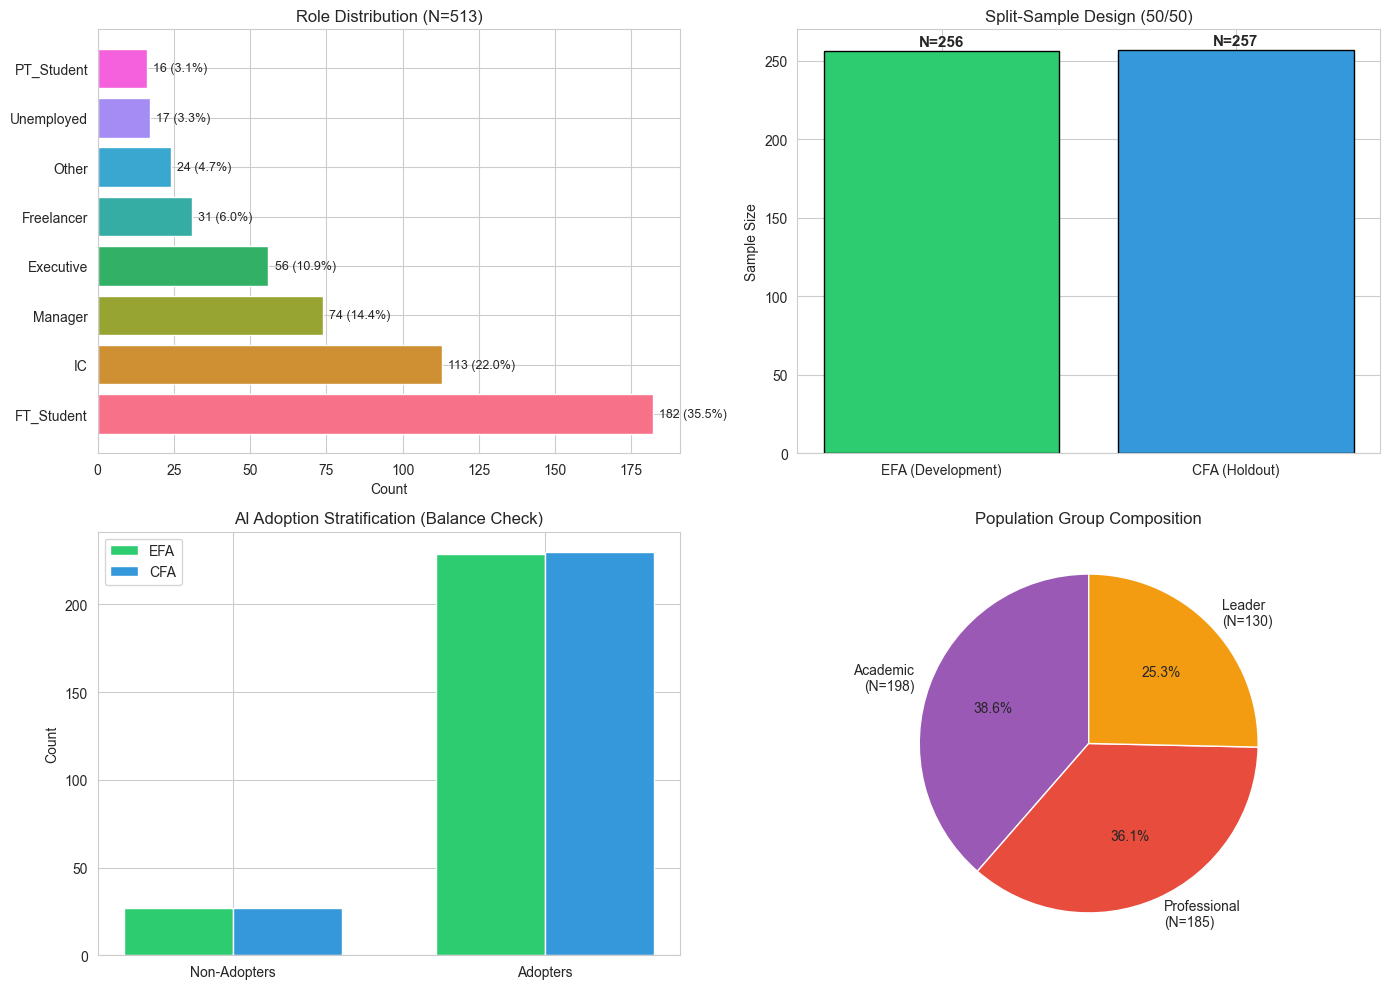

✅ Saved: plots/sample_preparation_overview.png


In [18]:
# ═══════════════════════════════════════════════════════════════════════════════
# SAMPLE VISUALIZATIONS
# ═══════════════════════════════════════════════════════════════════════════════
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Role Distribution
role_counts = df['Role_Category'].value_counts()
colors = sns.color_palette("husl", len(role_counts))
axes[0, 0].barh(role_counts.index, role_counts.values, color=colors)
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_title(f'Role Distribution (N={len(df)})')
for i, v in enumerate(role_counts.values):
    axes[0, 0].text(v + 2, i, f'{v} ({v/len(df)*100:.1f}%)', va='center', fontsize=9)

# 2. EFA vs CFA Split
split_data = pd.DataFrame({
    'Sample': ['EFA (Development)', 'CFA (Holdout)'],
    'N': [len(dev), len(holdout)]
})
bars = axes[0, 1].bar(split_data['Sample'], split_data['N'], 
                       color=['#2ecc71', '#3498db'], edgecolor='black')
axes[0, 1].set_ylabel('Sample Size')
axes[0, 1].set_title(f'Split-Sample Design ({int((1-HOLDOUT_RATIO)*100)}/{int(HOLDOUT_RATIO*100)})')
for bar, n in zip(bars, split_data['N']):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
                    f'N={n}', ha='center', fontsize=11, fontweight='bold')

# 3. AI Adoption by Sample
adoption_efa = dev['AI_Adoption'].value_counts().sort_index()
adoption_cfa = holdout['AI_Adoption'].value_counts().sort_index()
x = np.arange(2)
width = 0.35
bars1 = axes[1, 0].bar(x - width/2, [adoption_efa.get(0, 0), adoption_efa.get(1, 0)], 
                        width, label='EFA', color='#2ecc71')
bars2 = axes[1, 0].bar(x + width/2, [adoption_cfa.get(0, 0), adoption_cfa.get(1, 0)], 
                        width, label='CFA', color='#3498db')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Non-Adopters', 'Adopters'])
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('AI Adoption Stratification (Balance Check)')
axes[1, 0].legend()

# 4. Population Group Breakdown
pop_groups = {
    'Academic': ['FT_Student', 'PT_Student'], 
    'Professional': ['IC', 'Freelancer', 'Unemployed', 'Other'], 
    'Leader': ['Manager', 'Executive']
}
pop_counts = {g: df[df['Role_Category'].isin(roles)].shape[0] for g, roles in pop_groups.items()}
axes[1, 1].pie(pop_counts.values(), 
               labels=[f"{k}\n(N={v})" for k, v in pop_counts.items()], 
               autopct='%1.1f%%', 
               colors=['#9b59b6', '#e74c3c', '#f39c12'], 
               startangle=90)
axes[1, 1].set_title('Population Group Composition')

plt.tight_layout()
plt.savefig('./plots/sample_preparation_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved: plots/sample_preparation_overview.png")

# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 5: APA-STYLE SAMPLE DESCRIPTION
# ═══════════════════════════════════════════════════════════════════════════════

In [19]:
# ═══════════════════════════════════════════════════════════════════════════════
# APA-STYLE SAMPLE DESCRIPTION
# ═══════════════════════════════════════════════════════════════════════════════
from IPython.display import display, Markdown

# Calculate demographics
role_dist = df['Role_Category'].value_counts()
n_academic = role_dist.get('FT_Student', 0) + role_dist.get('PT_Student', 0)
n_professional = role_dist.get('IC', 0) + role_dist.get('Freelancer', 0) + role_dist.get('Unemployed', 0) + role_dist.get('Other', 0)
n_leader = role_dist.get('Manager', 0) + role_dist.get('Executive', 0)

# AI Adoption rates
adoption_rate = df['AI_Adoption'].mean() * 100
efa_adoption = dev['AI_Adoption'].mean() * 100
cfa_adoption = holdout['AI_Adoption'].mean() * 100

# Build APA text
apa_sample = f"""
### Sample Characteristics

**Participants.** The final sample consisted of *N* = {len(df)} participants representing adults in the United States 
who are either students or employed professionals, as specified in the approved dissertation proposal. 
The sample was stratified by AI adoption status and randomly split into development (*n* = {len(dev)}, {len(dev)/len(df)*100:.1f}%) 
and holdout (*n* = {len(holdout)}, {len(holdout)/len(df)*100:.1f}%) subsamples for split-sample validation.

**Role Distribution.** Participants included academic respondents (*n* = {n_academic}, {n_academic/len(df)*100:.1f}%; 
full-time students: *n* = {role_dist.get('FT_Student', 0)}, part-time students: *n* = {role_dist.get('PT_Student', 0)}), 
working professionals (*n* = {n_professional}, {n_professional/len(df)*100:.1f}%; 
individual contributors: *n* = {role_dist.get('IC', 0)}, freelancers: *n* = {role_dist.get('Freelancer', 0)}, 
unemployed: *n* = {role_dist.get('Unemployed', 0)}, other: *n* = {role_dist.get('Other', 0)}), 
and organizational leaders (*n* = {n_leader}, {n_leader/len(df)*100:.1f}%; 
managers: *n* = {role_dist.get('Manager', 0)}, executives: *n* = {role_dist.get('Executive', 0)}).

**AI Adoption.** Overall, {adoption_rate:.1f}% of participants reported active AI tool usage (more than "Never" on any tool). 
Stratified random sampling ensured comparable adoption rates across subsamples 
(EFA: {efa_adoption:.1f}%, CFA: {cfa_adoption:.1f}%).

**Split-Sample Design.** Following best practices for scale validation (Worthington & Whittaker, 2006), 
the development sample (*n* = {len(dev)}) was used for exploratory factor analysis (EFA), 
while the holdout sample (*n* = {len(holdout)}) was reserved for confirmatory factor analysis (CFA). 
This design provides independent cross-validation of the factor structure with a cases-to-items ratio 
of {len(dev)/len(PREDICTOR_ITEMS):.1f}:1 for EFA and {len(holdout)/len(PREDICTOR_ITEMS):.1f}:1 for CFA.
"""

display(Markdown(apa_sample))

# Summary table
print("\n" + "="*70)
print("SAMPLE SUMMARY TABLE")
print("="*70)
summary_df = pd.DataFrame({
    'Metric': ['Total N', 'EFA Sample', 'CFA Sample', 'Academic', 'Professional', 'Leader', 
               'AI Adopters', 'Cases per Item (EFA)'],
    'Value': [len(df), len(dev), len(holdout), n_academic, n_professional, n_leader, 
              f"{adoption_rate:.1f}%", f"{len(dev)/len(PREDICTOR_ITEMS):.1f}:1"]
})
print(summary_df.to_string(index=False))


### Sample Characteristics

**Participants.** The final sample consisted of *N* = 513 participants representing adults in the United States 
who are either students or employed professionals, as specified in the approved dissertation proposal. 
The sample was stratified by AI adoption status and randomly split into development (*n* = 256, 49.9%) 
and holdout (*n* = 257, 50.1%) subsamples for split-sample validation.

**Role Distribution.** Participants included academic respondents (*n* = 198, 38.6%; 
full-time students: *n* = 182, part-time students: *n* = 16), 
working professionals (*n* = 185, 36.1%; 
individual contributors: *n* = 113, freelancers: *n* = 31, 
unemployed: *n* = 17, other: *n* = 24), 
and organizational leaders (*n* = 130, 25.3%; 
managers: *n* = 74, executives: *n* = 56).

**AI Adoption.** Overall, 89.5% of participants reported active AI tool usage (more than "Never" on any tool). 
Stratified random sampling ensured comparable adoption rates across subsamples 
(EFA: 89.5%, CFA: 89.5%).

**Split-Sample Design.** Following best practices for scale validation (Worthington & Whittaker, 2006), 
the development sample (*n* = 256) was used for exploratory factor analysis (EFA), 
while the holdout sample (*n* = 257) was reserved for confirmatory factor analysis (CFA). 
This design provides independent cross-validation of the factor structure with a cases-to-items ratio 
of 10.7:1 for EFA and 10.7:1 for CFA.



SAMPLE SUMMARY TABLE
              Metric  Value
             Total N    513
          EFA Sample    256
          CFA Sample    257
            Academic    198
        Professional    185
              Leader    130
         AI Adopters  89.5%
Cases per Item (EFA) 10.7:1
